# <b>Deep learning basics - project<b>

##Imports

In [1]:
import numpy as np
import os
import pandas as pd
import math
import cv2
import tensorflow as tf
import io
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from concurrent.futures import ThreadPoolExecutor
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report , accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.manifold import TSNE
from tensorflow.keras import layers, models , regularizers
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential,load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization,SeparableConv2D,Activation,MaxPool2D,AveragePooling2D,UpSampling2D,Conv2DTranspose
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img, img_to_array
from tensorflow.keras.callbacks import EarlyStopping , LearningRateScheduler,ReduceLROnPlateau

## Google drive mounting + unzip files

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!unzip -q "/content/drive/MyDrive/archive.zip" -d "/content/"

## Model 1 - binary classification
   

### Data processing

In [4]:
img_size = 224
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_generator = train_datagen.flow_from_directory(
    "/content/chest_xray/train",
    target_size=(img_size, img_size),
    batch_size=32,
    class_mode='binary',
    shuffle=True,
    color_mode='grayscale'
)

test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    "/content/chest_xray/test",
    target_size=(img_size, img_size),
    batch_size=32,
    class_mode='binary',
    shuffle=False,
    color_mode='grayscale'
)


val_datagen = ImageDataGenerator(rescale=1./255)
val_generator = val_datagen.flow_from_directory(
    "/content/chest_xray/val",
    target_size=(img_size, img_size),
    batch_size=32,
    class_mode='binary',
    shuffle=True,
    color_mode='grayscale'
)

Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


### Display image

Label: 1.0


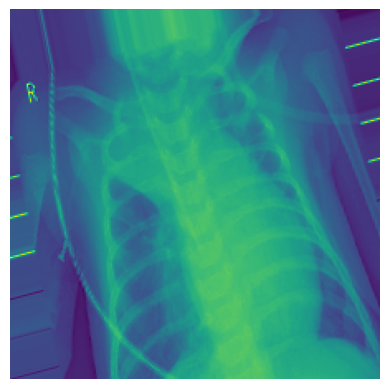

In [ ]:
import matplotlib.pyplot as plt

# Choose a batch index
batch_index = 0

# Get a batch from the generator
batch = next(train_generator)

# Choose an image index within the batch
image_index = 0

# Get the image and label
image = batch[0][image_index]
label = batch[1][image_index]

# Print the label (replace with your actual class labels if not binary)
print("Label:", label)

# Display the image using matplotlib
plt.imshow(image)
plt.axis('off')
plt.show()


### Early stopping function

In [ ]:
# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss',
                               patience=7,
                               restore_best_weights=True,
                               verbose=1)

### Model architecture

In [ ]:
# Define the model
model = Sequential()

# Block One
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(img_size, img_size, 1)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))

# Block Two
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.2))

# Block Three
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.3))

model.add(Conv2D(265, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.4))

# Flatten and Dense layers
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

# Final Layer (Output)
model.add(Dense(1, activation='sigmoid'))

In [ ]:
# Compile the model
model.compile(loss='binary_crossentropy'
              , optimizer = Adam(learning_rate=3e-5)
              , metrics='binary_accuracy')
model.summary()

### Training

In [ ]:
epochs = 2
steps_per_epoch = len(train_generator) // 2
history = model.fit(train_generator,
                    epochs=epochs,
                    steps_per_epoch=steps_per_epoch,
                    validation_data=val_generator)

Epoch 1/2
81/81 [==============================] - 27s 336ms/step - loss: 0.3251 - binary_accuracy: 0.8893 - val_loss: 0.5898 - val_binary_accuracy: 0.6875
Epoch 2/2
81/81 [==============================] - 27s 337ms/step - loss: 0.3293 - binary_accuracy: 0.9008 - val_loss: 0.7093 - val_binary_accuracy: 0.6875


### Results + statistics

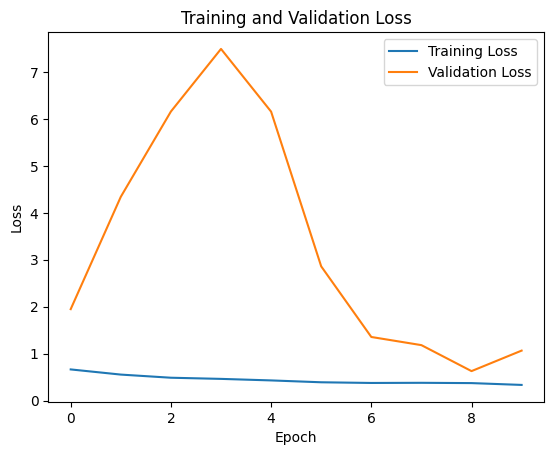

In [ ]:
# Plot the training and validation losses
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

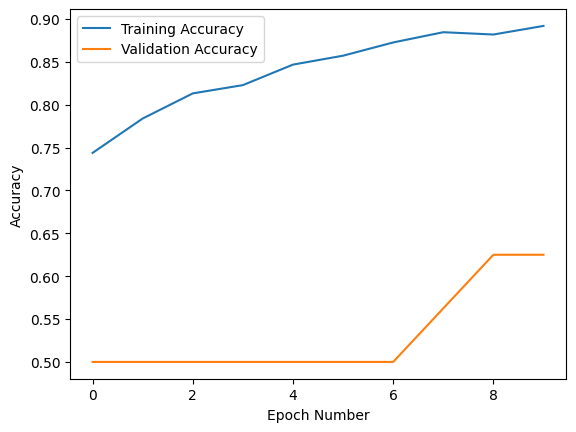

In [ ]:
plt.xlabel('Epoch Number')
plt.ylabel('Accuracy')
plt.plot(history.history['binary_accuracy'], label='Training Accuracy')
plt.plot(history.history['val_binary_accuracy'], label='Validation Accuracy')
plt.legend()
plt.show()

In [ ]:
# Make predictions on the test set
y_true = test_generator.classes
y_pred_prob = model.predict(test_generator)
y_pred = (y_pred_prob[:, 0] > 0.5).astype(int)  # Convert probabilities to binary predictions

# Create a binary confusion matrix
cm_binary = confusion_matrix(y_true, y_pred)

score = model.evaluate(test_generator, steps = len(test_generator), verbose = 0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])


# Visualize binary confusion matrix using seaborn
class_labels_binary = ['Healthy', 'Sick']
plt.figure(figsize=(6, 4))
sns.heatmap(cm_binary, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels_binary, yticklabels=class_labels_binary)
plt.title('Binary Confusion Matrix (Healthy vs. Sick)')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Print binary classification report
print("Binary Classification Report:\n", classification_report(y_true, y_pred, target_names=class_labels_binary))

20/20 [==============================] - 5s 127ms/step
Test loss: 0.3953554630279541
Test accuracy: 0.8733974099159241


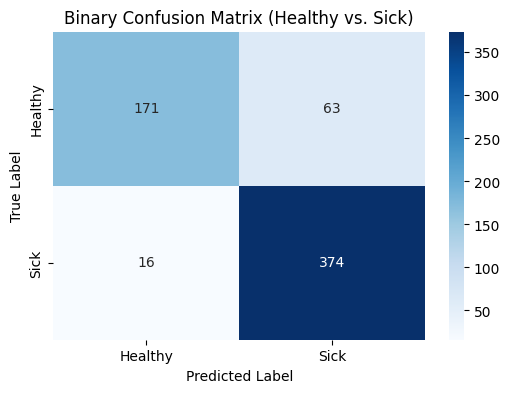

Binary Classification Report:
               precision    recall  f1-score   support

     Healthy       0.91      0.73      0.81       234
        Sick       0.86      0.96      0.90       390

    accuracy                           0.87       624
   macro avg       0.89      0.84      0.86       624
weighted avg       0.88      0.87      0.87       624



In [6]:
# Make predictions on the test set
loaded_model = load_model("/content/drive/MyDrive/FinalExercise/model1.keras")
y_true = test_generator.classes
y_pred_prob = loaded_model.predict(test_generator)
y_pred = (y_pred_prob[:, 0] > 0.5).astype(int)

# Create a binary confusion matrix
cm_binary = confusion_matrix(y_true, y_pred)

score = loaded_model.evaluate(test_generator, steps = len(test_generator), verbose = 0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])


# Visualize binary confusion matrix using seaborn
class_labels_binary = ['Healthy', 'Sick']
plt.figure(figsize=(6, 4))
sns.heatmap(cm_binary, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels_binary, yticklabels=class_labels_binary)
plt.title('Binary Confusion Matrix (Healthy vs. Sick)')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Print binary classification report
print("Binary Classification Report:\n", classification_report(y_true, y_pred, target_names=class_labels_binary))

### Save model

In [ ]:
#option to save model if it's better then the one before
model.save('/content/drive/MyDrive/FinalExercise/model1.keras')

## Model 2 - multi-class classification

### Data processing

In [7]:
img_size = 224
base_directory = "/content/chest_xray"
batch_size = 32

def map_filename_to_labels(filename):
    if 'NORMAL' in filename:
        return 0  # 'Normal'
    elif 'bacteria' in filename:
        return 1  # 'Bacterial_Pneumonia'
    elif 'virus' in filename:
        return 2  # 'Viral_Pneumonia'
    else:
        raise ValueError(f"Unexpected filename: {filename}")

class CustomDataGenerator(tf.keras.utils.Sequence):
    def __init__(self, directory, filenames, labels, batch_size, augmentation=False):
        self.directory = directory
        self.filenames = filenames
        self.labels = labels
        self.batch_size = batch_size
        self.augmentation = augmentation
        self.class_indices = {'Normal': 0, 'Bacterial_Pneumonia': 1, 'Viral_Pneumonia': 2}
        self.num_classes = len(self.class_indices)

        # Initialize the ImageDataGenerator for augmentation
        if self.augmentation:
            self.image_data_generator = tf.keras.preprocessing.image.ImageDataGenerator(
                rotation_range=10,
                width_shift_range=0.05,
                height_shift_range=0.05,
                shear_range=0.05,
                zoom_range=0.1,
                horizontal_flip=True,
                vertical_flip=False,
                fill_mode='nearest',
            )
        else:
            self.image_data_generator = None

    def __len__(self):
        if self.labels is not None:
            return int(np.ceil(len(self.filenames) / self.batch_size))
        else:
            return int(np.ceil(len(self.filenames) / self.batch_size))

    def __getitem__(self, index):
        start = index * self.batch_size
        end = (index + 1) * self.batch_size
        batch_x = self._load_images(self.filenames[start:end])

        if self.augmentation:
            # Apply data augmentation
            batch_x = self._augment_images(batch_x)

        batch_y = self.labels[start:end] if self.labels is not None else None
        if batch_y is not None:
            batch_y = tf.keras.utils.to_categorical(batch_y, num_classes=self.num_classes)

        return batch_x, batch_y

    def _load_images(self, batch_filenames):
        batch_images = []
        for filename in batch_filenames:
            image = tf.keras.preprocessing.image.load_img(filename, target_size=(img_size, img_size),color_mode='grayscale')
            image = tf.keras.preprocessing.image.img_to_array(image)
            image = image / 255.0
            batch_images.append(image)
        return np.array(batch_images)

    def _augment_images(self, batch_images):
        batch_images = np.array(batch_images)
        batch_images_reshaped = batch_images.reshape((-1, img_size, img_size, 1))

        # Apply data augmentation
        augmented_images = augmented_images = self.image_data_generator.flow(batch_images_reshaped, shuffle=False).next()
        augmented_images = augmented_images.reshape((-1, img_size, img_size, 1))

        return augmented_images

# Get all filenames and manually assign labels based on the filename
all_filenames = [os.path.join(dp, f) for dp, dn, filenames in os.walk(os.path.join(base_directory, 'train')) for f in filenames]
all_labels = [map_filename_to_labels(filename) for filename in all_filenames]

# Split the data ensuring proportional representation of each class in train and val sets
train_filenames, val_filenames, train_labels, val_labels = train_test_split(
    all_filenames, all_labels, test_size=0.2, stratify=all_labels, random_state=42)

# Create custom data generators
train_data = CustomDataGenerator(base_directory, train_filenames, train_labels, batch_size, augmentation=True)
val_data = CustomDataGenerator(base_directory, val_filenames, val_labels, batch_size, augmentation=False)

# Test data
test_filenames = [os.path.join(dp, f) for dp, dn, filenames in os.walk(os.path.join(base_directory, 'test')) for f in filenames]
test_labels = [map_filename_to_labels(filename) for filename in test_filenames]
test_data = CustomDataGenerator(base_directory, test_filenames, test_labels, batch_size, augmentation=False)

unique_train_labels = set(train_labels)
print("Unique labels in training data:", unique_train_labels)

unique_val_labels = set(val_labels)
print("Unique labels in val data:", unique_val_labels)

unique_test_labels = set(test_labels)
print("Unique labels in val data:", unique_test_labels)

Unique labels in training data: {0, 1, 2}
Unique labels in val data: {0, 1, 2}
Unique labels in val data: {0, 1, 2}


### Model architecture

In [ ]:
# Model architecture
model2 = Sequential()

model2.add(Conv2D(32, (3, 3), activation='relu', input_shape=(img_size, img_size, 1)))
model2.add(BatchNormalization())
model2.add(MaxPooling2D((2, 2), padding='same'))

model2.add(Conv2D(64, (3, 3), activation='relu'))
model2.add(BatchNormalization())
model2.add(MaxPooling2D((2, 2), padding='same'))

model2.add(Conv2D(128, (3, 3), activation='relu'))
model2.add(BatchNormalization())
model2.add(MaxPooling2D((2, 2), padding='same'))
model2.add(Dropout(0.2))

model2.add(Conv2D(256, (3, 3), activation='relu'))
model2.add(BatchNormalization())
model2.add(MaxPooling2D((2, 2), padding='same'))
model2.add(Dropout(0.3))

model2.add(Flatten())
model2.add(Dense(128, activation='relu'))
model2.add(Dropout(0.5))
model2.add(Dense(3, activation='softmax'))

# Model compilation
optimizer = Adam(learning_rate=1e-3)
model2.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 222, 222, 32)      320       
                                                                 
 batch_normalization_4 (Bat  (None, 222, 222, 32)      128       
 chNormalization)                                                
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 111, 111, 32)      0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 batch_normalization_5 (Bat  (None, 109, 109, 64)      256       
 chNormalization)                                                
                                                      

### Training

In [ ]:
steps_per_epoch = len(train_data) // 2
history = model2.fit(
    train_data,
    epochs=10,
    validation_data=val_data,
    steps_per_epoch=steps_per_epoch,
    callbacks=[early_stopping]
)

Epoch 1/10
65/65 [==============================] - 35s 495ms/step - loss: 2.9830 - accuracy: 0.5019 - val_loss: 12.2147 - val_accuracy: 0.4847
Epoch 2/10
65/65 [==============================] - 28s 427ms/step - loss: 0.9456 - accuracy: 0.5361 - val_loss: 14.0528 - val_accuracy: 0.4847
Epoch 3/10
65/65 [==============================] - 28s 428ms/step - loss: 0.8755 - accuracy: 0.5659 - val_loss: 11.8091 - val_accuracy: 0.4808
Epoch 4/10
65/65 [==============================] - 33s 503ms/step - loss: 0.8274 - accuracy: 0.5808 - val_loss: 15.6598 - val_accuracy: 0.2634
Epoch 5/10
65/65 [==============================] - 32s 484ms/step - loss: 0.7937 - accuracy: 0.5883 - val_loss: 8.5857 - val_accuracy: 0.4847
Epoch 6/10
65/65 [==============================] - 27s 417ms/step - loss: 0.7892 - accuracy: 0.6221 - val_loss: 3.8275 - val_accuracy: 0.4847
Epoch 7/10
65/65 [==============================] - 28s 424ms/step - loss: 0.7901 - accuracy: 0.6282 - val_loss: 2.4016 - val_accuracy: 0.

### Results + statistics

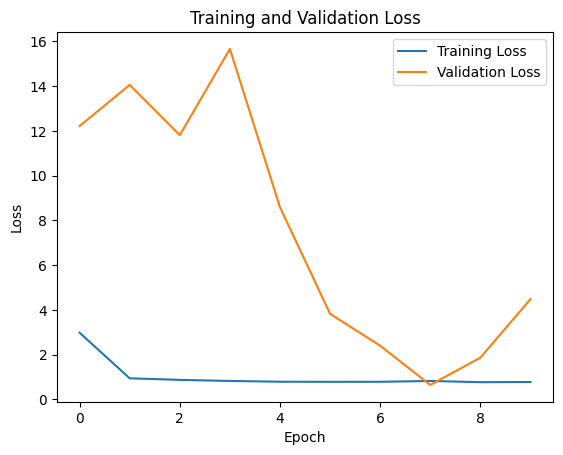

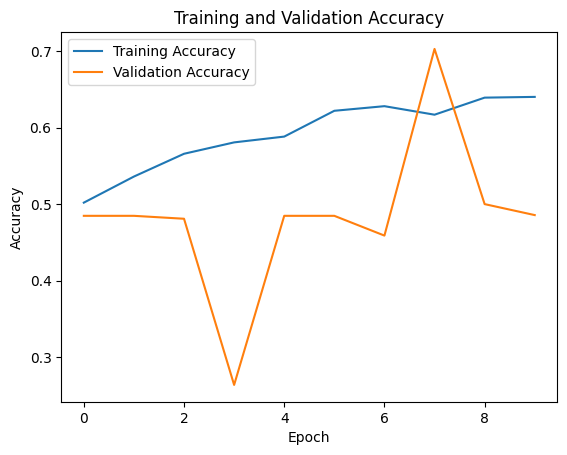

In [ ]:
# Plot loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

20/20 [==============================] - 6s 292ms/step
Classification Report:
                      precision    recall  f1-score   support

             Normal       0.00      0.00      0.00       234
Bacterial_Pneumonia       0.39      1.00      0.56       242
    Viral_Pneumonia       0.00      0.00      0.00       148

           accuracy                           0.39       624
          macro avg       0.13      0.33      0.19       624
       weighted avg       0.15      0.39      0.22       624

Accuracy Rate: 0.3878


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


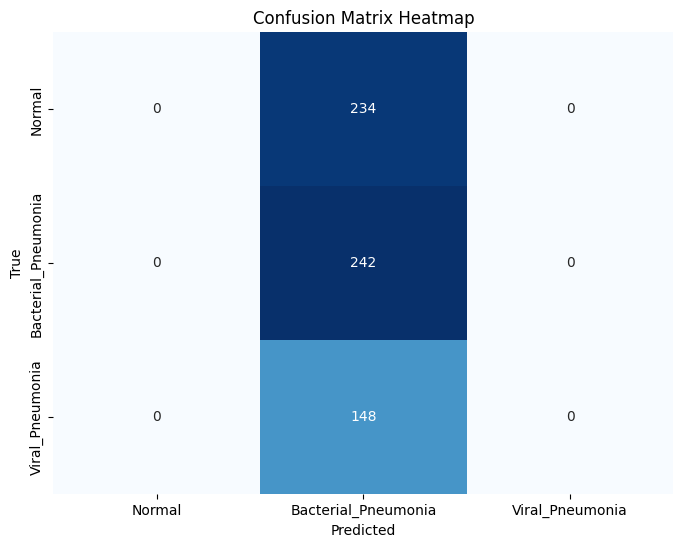

In [ ]:
# Evaluate the model on the test set
y_true = test_data.labels

# Predict probabilities
y_pred_probs = model2.predict(test_data, steps=len(test_data), verbose=1)

# Convert probabilities to class labels
y_pred_classes = np.argmax(y_pred_probs, axis=1)

# Display classification report
class_names = ['Normal', 'Bacterial_Pneumonia', 'Viral_Pneumonia']
print("Classification Report:\n", classification_report(y_true, y_pred_classes, target_names=class_names))

# Calculate and display accuracy
accuracy = accuracy_score(y_true, y_pred_classes)
print(f'Accuracy Rate: {accuracy:.4f}')

# Generate and display confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix Heatmap')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


In [ ]:
#option to save model if it's better then the one before
model2.save('/content/drive/MyDrive/FinalExercise/model2.keras')

20/20 [==============================] - 3s 142ms/step
Classification Report:
                      precision    recall  f1-score   support

             Normal       0.92      0.85      0.88       234
Bacterial_Pneumonia       0.86      0.90      0.88       242
    Viral_Pneumonia       0.74      0.76      0.75       148

           accuracy                           0.85       624
          macro avg       0.84      0.84      0.84       624
       weighted avg       0.85      0.85      0.85       624

Accuracy Rate: 0.8494


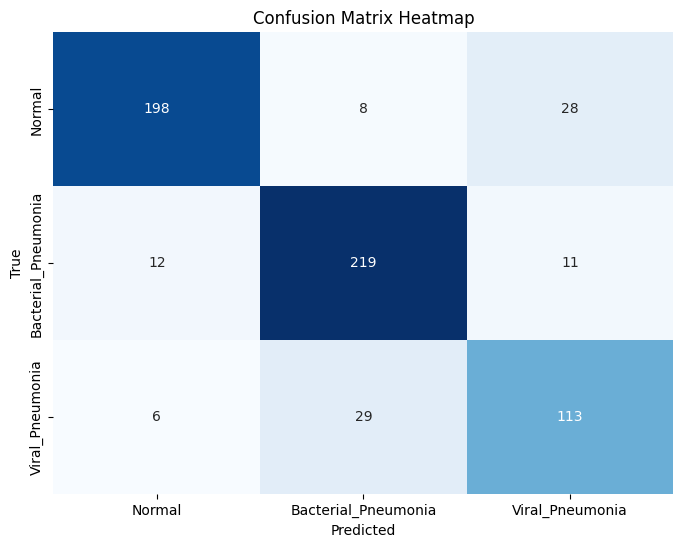

In [8]:
# Evaluate the model on the test set
loaded_model2 = load_model("/content/drive/MyDrive/FinalExercise/model2.keras")
y_true = test_data.labels

# Predict probabilities
y_pred_probs = loaded_model2.predict(test_data, steps=len(test_data), verbose=1)

# Convert probabilities to class labels
y_pred_classes = np.argmax(y_pred_probs, axis=1)

# Display classification report
class_names = ['Normal', 'Bacterial_Pneumonia', 'Viral_Pneumonia']
print("Classification Report:\n", classification_report(y_true, y_pred_classes, target_names=class_names))

# Calculate and display accuracy
accuracy = accuracy_score(y_true, y_pred_classes)
print(f'Accuracy Rate: {accuracy:.4f}')

# Generate and display confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix Heatmap')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


## Embedding vector + KNN

### Extract embeddings + training KNN

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
import joblib

loaded_model2 = load_model("/content/drive/MyDrive/FinalExercise/model2.keras")
train_embeddings = []
train_labels = []

# Loop through the train_data generator to extract embeddings and labels
for batch_x, batch_y in train_data:
    embeddings = loaded_model2.predict(batch_x)
    train_embeddings.extend(embeddings)
    train_labels.extend(batch_y.argmax(axis=1))

# Convert lists to numpy arrays
train_embeddings = np.array(train_embeddings)
train_labels = np.array(train_labels)

# Step 2: Train a KNN classifier using the embeddings and their corresponding labels
knn_classifier = KNeighborsClassifier(n_neighbors=5)
knn_classifier.fit(train_embeddings, train_labels)

### Test the KNN with testset

1/1 [==============================] - 0s 19ms/step
Accuracy Rate: 0.7821


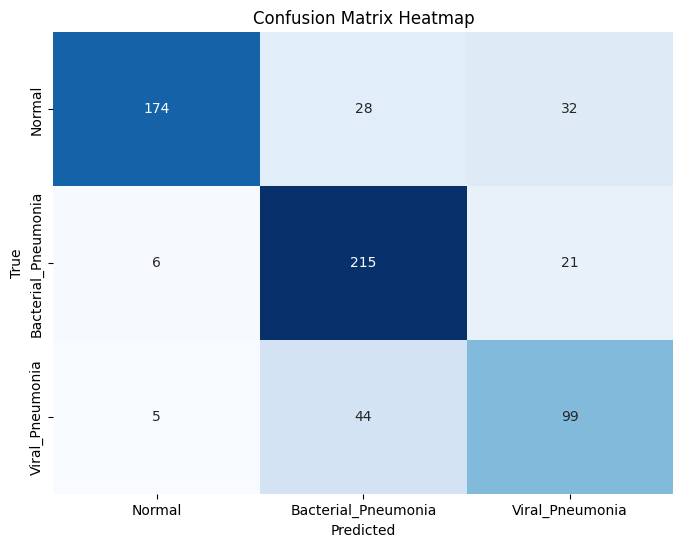


Classification Report:
                      precision    recall  f1-score   support

             Normal       0.94      0.74      0.83       234
Bacterial_Pneumonia       0.75      0.89      0.81       242
    Viral_Pneumonia       0.65      0.67      0.66       148

           accuracy                           0.78       624
          macro avg       0.78      0.77      0.77       624
       weighted avg       0.80      0.78      0.78       624



In [11]:
# Load the test data
test_embeddings = []
test_labels = []
class_names = ['Normal', 'Bacterial_Pneumonia', 'Viral_Pneumonia']

# Loop through the test_data generator to extract embeddings and labels
for batch_x, batch_y in test_data:
    embeddings = loaded_model2.predict(batch_x)
    test_embeddings.extend(embeddings)
    test_labels.extend(batch_y.argmax(axis=1))

# Convert lists to numpy arrays
test_embeddings = np.array(test_embeddings)
test_labels = np.array(test_labels)

# Predict with KNN
predicted_labels = knn_classifier.predict(test_embeddings)

# Generate confusion matrix
from sklearn.metrics import confusion_matrix, classification_report
conf_matrix = confusion_matrix(test_labels, predicted_labels)

# Calculate accuracy, precision, recall, and F1-score
accuracy = np.trace(conf_matrix) / float(np.sum(conf_matrix))
precision = np.diag(conf_matrix) / np.sum(conf_matrix, axis=0)
recall = np.diag(conf_matrix) / np.sum(conf_matrix, axis=1)
f1_score = 2 * (precision * recall) / (precision + recall)

# Calculate and display accuracy
accuracy = accuracy_score(test_labels, predicted_labels)
print(f'Accuracy Rate: {accuracy:.4f}')

# Generate and display confusion matrix
conf_matrix = confusion_matrix(test_labels, predicted_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix Heatmap')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Display classification report
print("\nClassification Report:\n", classification_report(test_labels, predicted_labels, target_names=class_names))


### KNN - save

In [ ]:
save_path = '/content/drive/MyDrive/FinalExercise/knn_classifier.joblib'
joblib.dump(knn_classifier, save_path)

### Prediction + visualization

1/1 [==============================] - 0s 55ms/step


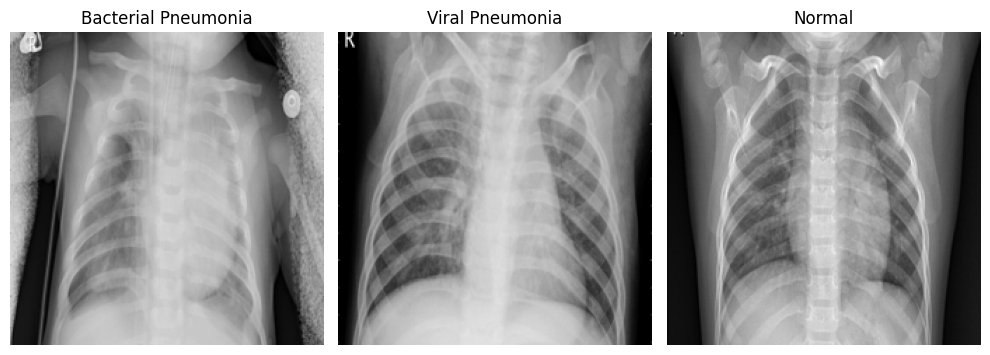

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt

# For predictions:
new_image_paths = ['/content/chest_xray/test/PNEUMONIA/person100_bacteria_478.jpeg', '/content/chest_xray/test/PNEUMONIA/person26_virus_60.jpeg','/content/chest_xray/test/NORMAL/IM-0049-0001.jpeg']

# Create a figure to hold the subplots
fig = plt.figure(figsize=(10, 5))

# Display images and print predicted labels
for idx, path in enumerate(new_image_paths):
    # Load and resize image
    img = Image.open(path)
    img = img.resize((img_size, img_size))

    # Convert image to array and normalize
    img_array = np.array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)
    img_array = np.expand_dims(img_array, axis=-1)

    # Predict label
    embedding = loaded_model2.predict(img_array)
    predicted_label = knn_classifier.predict(embedding)

    # Add subplot
    ax = fig.add_subplot(1, len(new_image_paths), idx + 1)

    # Display image
    ax.imshow(img, cmap='gray')
    ax.axis('off')

    # Print predicted label
    if predicted_label == 0:
        ax.set_title("Normal")
    elif predicted_label == 1:
        ax.set_title("Bacterial Pneumonia")
    elif predicted_label == 2:
        ax.set_title("Viral Pneumonia")

plt.tight_layout()
plt.show()

### t-sne visualization

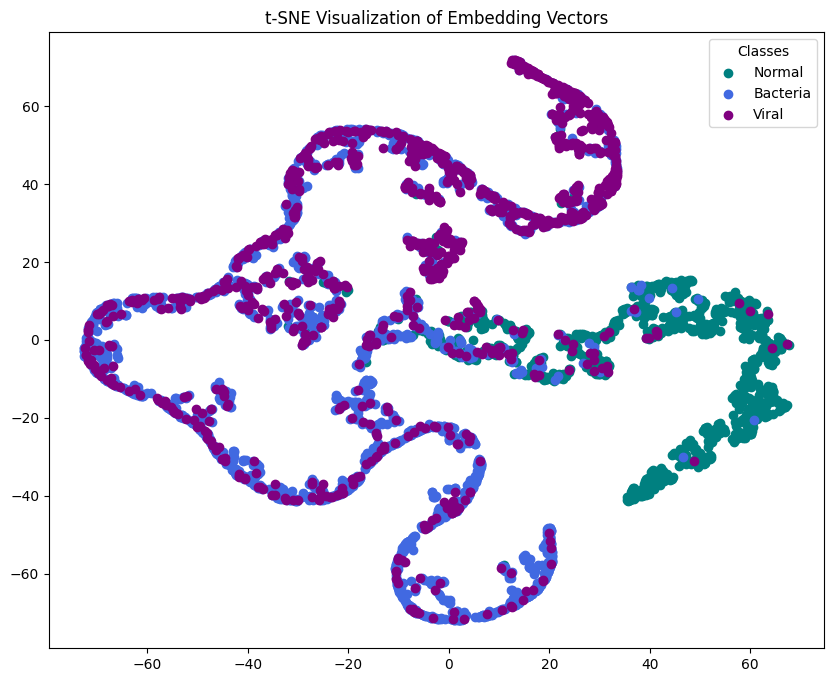

In [ ]:
tsne = TSNE(n_components=2, random_state=42)
embedded_data = tsne.fit_transform(train_embeddings)

# Define class names and colors
class_names = ['Normal', 'Bacteria', 'Viral']
class_labels = [0, 1, 2]
colors = ['teal', 'royalblue', 'purple']

# Plot t-SNE visualization
plt.figure(figsize=(10, 8))
for i, label in enumerate(class_labels):
    indices = train_labels == label
    plt.scatter(embedded_data[indices, 0], embedded_data[indices, 1], c=colors[i], label=class_names[i])

plt.legend(title='Classes')
plt.title('t-SNE Visualization of Embedding Vectors')
plt.show()


## Anomaly detection

### Data processing

In [12]:
img_size = 224

# Directory path for training normal images
normal_train_dir = "/content/chest_xray/train/NORMAL"
normal_test_dir = "/content/chest_xray/test/NORMAL"
pneumonia_test_dir = "/content/chest_xray/test/PNEUMONIA"

# Function to load and preprocess images
def load_images_from_folder(folder):
    images = []
    for filename in os.listdir(folder):
        img_path = os.path.join(folder, filename)
        img = load_img(img_path, target_size=(img_size, img_size), color_mode='grayscale')
        img_array = img_to_array(img) / 255.0
        images.append(img_array)
    return np.array(images)

# Load training images (normal)
normal_train_images = load_images_from_folder(normal_train_dir)

# Convert the loaded images to numpy array
normal_train_images = np.array(normal_train_images)

# Print the number of images after conversion
print("Number of images after conversion:", len(normal_train_images))

# Load test images
pneumonia_test_images = load_images_from_folder(pneumonia_test_dir)
normal_test_images = load_images_from_folder(normal_test_dir)

print("Number of normal in test:", len(normal_test_images))
print("Number of pneumonia in test:", len(pneumonia_test_images))

all_test_images = np.concatenate((normal_test_images, pneumonia_test_images), axis=0)
all_test_images = np.array(all_test_images)

# Print the length of the combined test images array
print("Length of combined test images:", len(all_test_images))

train_images, val_images = train_test_split(normal_train_images, test_size=0.2, random_state=42)


# Create an ImageDataGenerator instance for augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

# Augment the training images
augmented_images = []
for image in train_images:
    augmented_image = datagen.random_transform(image)
    augmented_images.append(augmented_image)

# Convert the augmented images to numpy array
augmented_images = np.array(augmented_images)

# Print the number of images after augmentation
print("Number of images after augmentation:", len(augmented_images))

Number of images after conversion: 1341
Number of normal in test: 234
Number of pneumonia in test: 390
Length of combined test images: 624
Number of images after augmentation: 1072


### Model architecture

In [ ]:
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Conv2DTranspose, BatchNormalization
from keras.models import Model
from keras.optimizers import Adam

# Define the input layer
input_img = Input(shape=(img_size, img_size, 1))

# Encoder layers
x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
encoded = BatchNormalization()(x)

# Decoder layers
x = Conv2DTranspose(256, (3, 3), activation='relu', padding='same')(encoded)
x = BatchNormalization()(x)
x = Conv2DTranspose(128, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = UpSampling2D((2, 2))(x)
x = Conv2DTranspose(64, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = UpSampling2D((2, 2))(x)
x = Conv2DTranspose(32, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = UpSampling2D((2, 2))(x)
x = Conv2DTranspose(16, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = Conv2DTranspose(8, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
decoded = Conv2DTranspose(1, (3, 3), activation='sigmoid', padding='same')(x)

# Autoencoder model
autoencoder = Model(input_img, decoded)

# Compile the autoencoder model
optimizer = Adam(learning_rate=1e-3)
autoencoder.compile(optimizer=optimizer, loss='mean_squared_error')
autoencoder.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 224, 224, 1)]     0         
                                                                 
 conv2d_16 (Conv2D)          (None, 224, 224, 32)      320       
                                                                 
 batch_normalization_40 (Ba  (None, 224, 224, 32)      128       
 tchNormalization)                                               
                                                                 
 max_pooling2d_12 (MaxPooli  (None, 112, 112, 32)      0         
 ng2D)                                                           
                                                                 
 conv2d_17 (Conv2D)          (None, 112, 112, 64)      18496     
                                                                 
 batch_normalization_41 (Ba  (None, 112, 112, 64)      256 

### Training

In [ ]:
# Fit the autoencoder model on the normal training images
history = autoencoder.fit(train_images, train_images,
                epochs=20,
                batch_size=32,
                validation_data=(val_images, val_images),
                shuffle=True)

Epoch 1/20
34/34 [==============================] - 13s 194ms/step - loss: 0.0115 - val_loss: 0.0525
Epoch 2/20
34/34 [==============================] - 6s 178ms/step - loss: 0.0041 - val_loss: 0.0497
Epoch 3/20
34/34 [==============================] - 6s 177ms/step - loss: 0.0031 - val_loss: 0.0494
Epoch 4/20
34/34 [==============================] - 6s 179ms/step - loss: 0.0027 - val_loss: 0.0434
Epoch 5/20
34/34 [==============================] - 6s 178ms/step - loss: 0.0024 - val_loss: 0.0395
Epoch 6/20
34/34 [==============================] - 6s 179ms/step - loss: 0.0023 - val_loss: 0.0396
Epoch 7/20
34/34 [==============================] - 6s 184ms/step - loss: 0.0022 - val_loss: 0.0325
Epoch 8/20
34/34 [==============================] - 6s 181ms/step - loss: 0.0021 - val_loss: 0.0314
Epoch 9/20
34/34 [==============================] - 6s 179ms/step - loss: 0.0020 - val_loss: 0.0285
Epoch 10/20
34/34 [==============================] - 6s 187ms/step - loss: 0.0020 - val_loss: 0.023

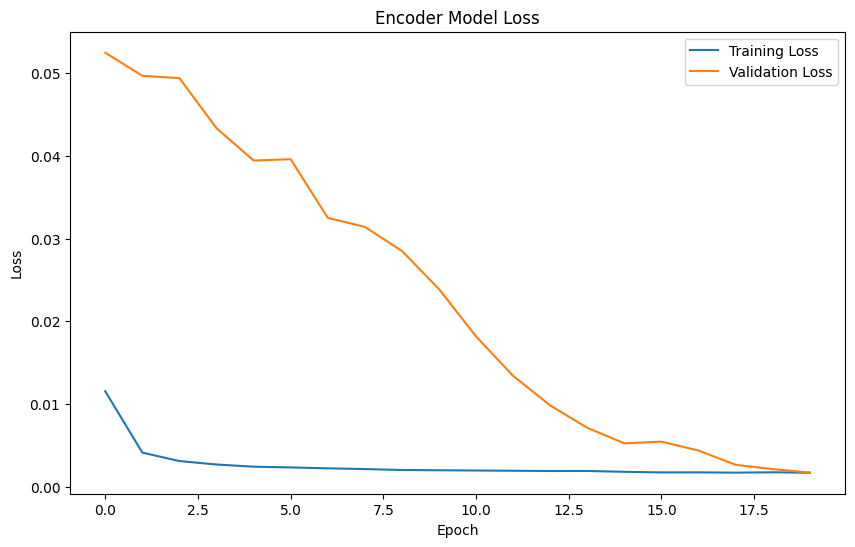

In [ ]:
# Plot the training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Encoder Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Best threshold

In [ ]:
from sklearn.metrics import f1_score

# Generate reconstructions on validation set
val_predictions = autoencoder.predict(val_images)

# Calculate reconstruction errors
val_reconstruction_errors = np.mean(np.square(val_images - val_predictions), axis=(1, 2, 3))

# Create labels for validation set (assuming all normal)
val_labels = np.zeros(len(val_images))

# Evaluate different thresholds
thresholds = np.linspace(0, 0.03, 1000)
best_threshold = None
best_score = 0

for threshold in thresholds:
    # Classify images based on threshold
    predictions = (val_reconstruction_errors > threshold).astype(int)

    # Evaluate performance using F1-score
    f1 = f1_score(val_labels, predictions, zero_division=1)

    # Update best threshold if needed
    if f1 > best_score:
        best_score = f1
        best_threshold = threshold

print("Best Threshold:", best_threshold)
print("Best F1 Score:", best_score)

9/9 [==============================] - 0s 55ms/step
Best Threshold: 0.0024324324324324323
Best F1 Score: 1.0


### Predictions

In [ ]:
# Predict on the combined test set
test_predictions = autoencoder.predict(all_test_images)

# Calculate reconstruction error for each image
reconstruction_errors = np.mean(np.square(all_test_images - test_predictions), axis=(1, 2, 3))

# Classify images as normal (below threshold) or anomalous (above threshold)
predictions = (reconstruction_errors > best_threshold).astype(int)

# Count the number of predicted pneumonia cases
num_pneumonia_predicted = np.sum(predictions == 1)

print("Number of pneumonia cases predicted:", num_pneumonia_predicted)

20/20 [==============================] - 1s 53ms/step
Number of pneumonia cases predicted: 32


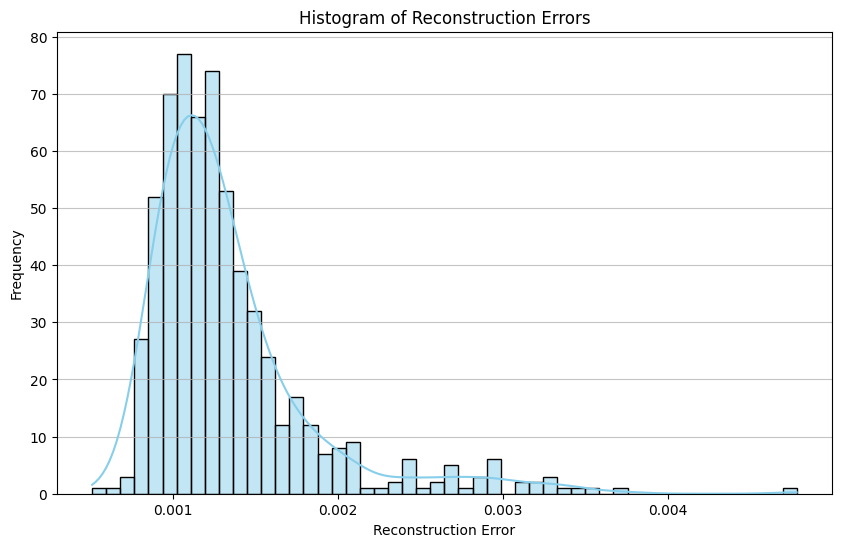

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot a histogram of reconstruction errors
plt.figure(figsize=(10, 6))
sns.histplot(reconstruction_errors, bins=50, kde=True, color='skyblue')
plt.title('Histogram of Reconstruction Errors')
plt.xlabel('Reconstruction Error')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)
plt.show()


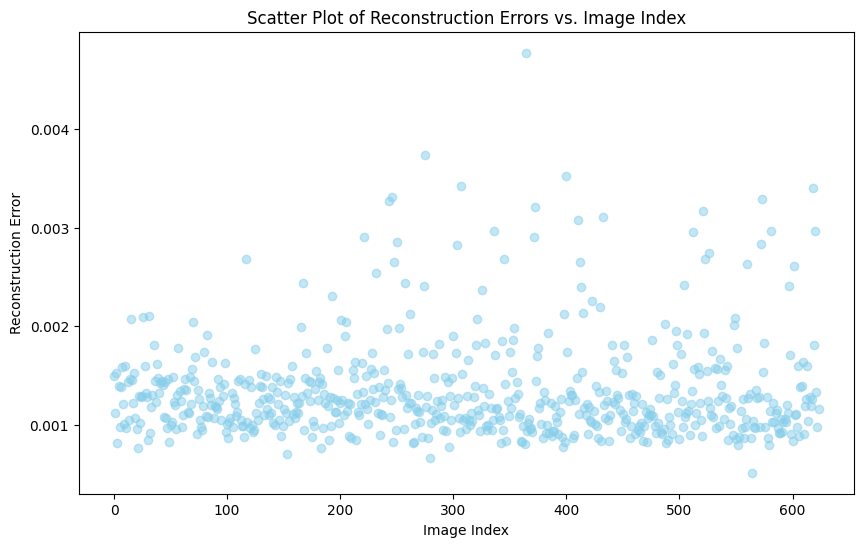

In [ ]:
plt.figure(figsize=(10, 6))
plt.scatter(range(len(reconstruction_errors)), reconstruction_errors, color='skyblue', alpha=0.5)
plt.title('Scatter Plot of Reconstruction Errors vs. Image Index')
plt.xlabel('Image Index')
plt.ylabel('Reconstruction Error')
plt.show()


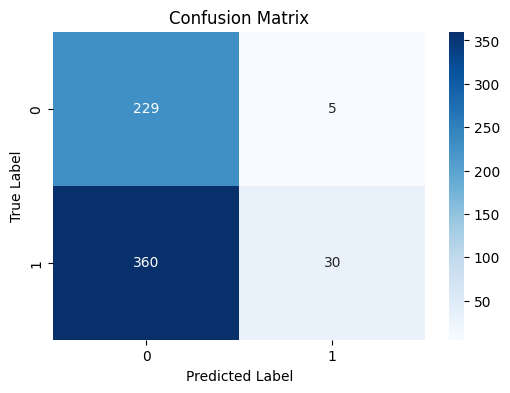

Classification Report:
              precision    recall  f1-score   support

      Normal       0.39      0.98      0.56       234
   Pneumonia       0.86      0.08      0.14       390

    accuracy                           0.42       624
   macro avg       0.62      0.53      0.35       624
weighted avg       0.68      0.42      0.30       624



In [ ]:
# True labels for the test set
true_labels = np.array([0] * len(normal_test_images) + [1] * len(pneumonia_test_images))

# Calculate the confusion matrix
conf_matrix = confusion_matrix(true_labels, predictions)

# Display the confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Print the classification report
print("Classification Report:")
print(classification_report(true_labels, predictions, target_names=['Normal', 'Pneumonia']))


### Save model

In [ ]:
#option to save model if it's better then the one before
autoencoder.save('/content/drive/MyDrive/FinalExercise/autoencoder.keras')

### Reconstructed images

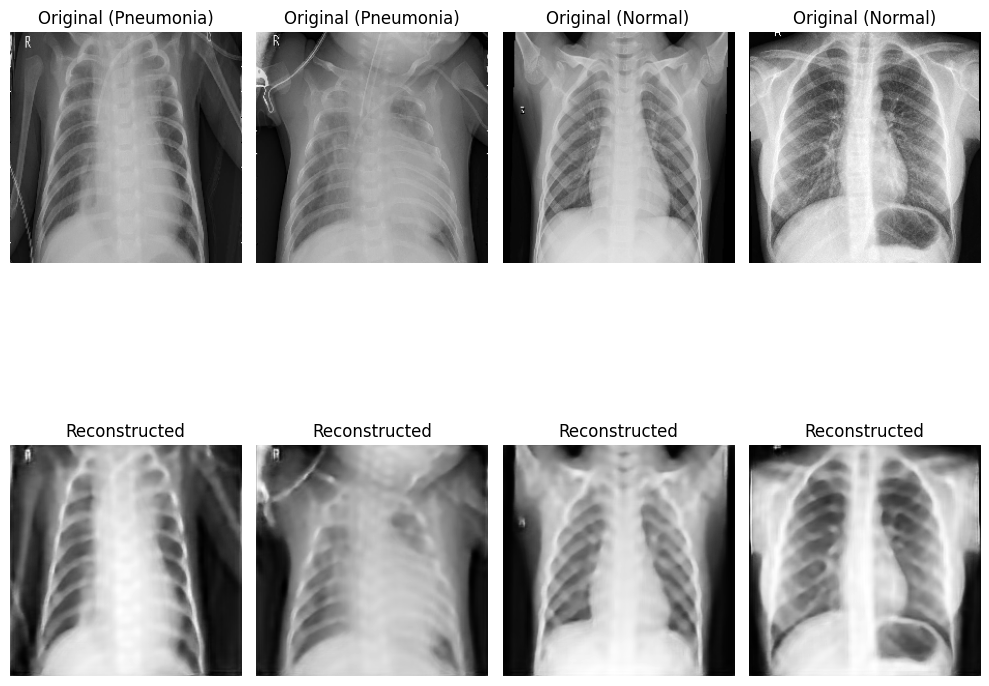

In [ ]:
import matplotlib.pyplot as plt

# Select four random indices
indices = np.random.randint(0, len(all_test_images), size=4)

# Define the labels
labels = ["Normal" if idx < len(normal_test_images) else "Pneumonia" for idx in indices]

# Plot original and reconstructed images with labels
plt.figure(figsize=(10, 10))
for i, (idx, label) in enumerate(zip(indices, labels)):
    # Original image
    plt.subplot(2, 4, i+1)
    plt.imshow(all_test_images[idx].reshape(img_size, img_size), cmap='gray')
    plt.title(f"Original ({label})")
    plt.axis('off')

    # Reconstructed image
    plt.subplot(2, 4, i+5)
    plt.imshow(test_predictions[idx].reshape(img_size, img_size), cmap='gray')
    plt.title("Reconstructed")
    plt.axis('off')

plt.tight_layout()
plt.show()
